<a href="https://colab.research.google.com/github/keith-leung/Celia/blob/master/MDPs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TODOs:

# MDPs:
# Visualize index_to_state mapping
# Debug probability table construction

# TRL:
# Improve α formula to get better u estimate
# Change explore/exploit decision to get better u estimate
# Enlarge the grid size

In [ ]:
"""
Policy iteration algorithm
This algorithm finds an optimal policy when the rewards, discount factor, and transition probabilities are all known
It starts with an initial guess and iteratively updates its policy until it is optimal
On each iteration, it evaluates its current policy and then improves itk
"""

import numpy as np # used for handling arrays
import itertools as it # used for fancy iteration methods

# r[i]: reward at the ith state
# ɣ: discount factor in the interval (0, 1)
# P[k,i,j]: Transition probability Pr{S(t+1) = s_j | S(t) = s_i, A(t) = a_k}
# num_iters: maximum number of iterations to perform (None goes to convergence)
# verbose: if True, print status updates during iteration
def policy_iteration(r, ɣ, P, num_iters=None, verbose=False):

    N = len(r) # Total number of states
    π = np.zeros(N).astype(int) # Initial policy: a_0 in every state

    for n in it.count(): # Iterates n = 0, 1, 2, ... forever
        if n == num_iters: break # But break early if num_iters reached

        ### Policy evaluation step

        # Form transition probability matrix given current policy:
        # P_π[i,j] = Pr{S(t+1) = s_j | S(t) = s_i, A(t) = π(s_i)}
        P_π = np.array([P[π[i], i, :] for i in range(N)])

        # Solve Bellman's equation to get the utility of each state, given π
        # u[i]: utility of state s_i
        # Bellman's equation:   u = r + ɣ*P_π.dot(u)
        # Solving for u:        u = inv(I - ɣ*P_π).dot(r)
        u = np.linalg.solve(np.eye(N) - ɣ*P_π, r)

        # Print status update
        if verbose: print("iter %d π=%s, u= %s"%(n,π,u))

        ### Policy improvement step
        
        # Using current utility u for policy π,
        # choose the action which maximizes expected utility to get a new policy π_new
        # This is called "one-step lookahead"
        π_new = (P*u.reshape(1,1,N)).sum(axis=2).argmax(axis=0)

        # If the policy hasn't changed, policy iteration is complete
        if (π == π_new).all(): return π, u
        
        # Otherwise, replace the old policy with the new one and repeat
        π = π_new


In [ ]:
# Domain API
# state (mx, my, cx, cy) are xy positions of mouse and cat
# Each can move one unit vertically, horizontally, or diagonally
# The cat moves uniformly at random, the mouse is the agent
# Reward is maximized by staying far from the cat

# The mouse and cat live in a discrete rectangular grid
# If they try to move outside the grid, they stay where they are
#grid_rows, grid_cols = 4, 4
grid_rows, grid_cols = 25, 25 # TODO: try larger grid size
num_states = (grid_rows*grid_cols)**2 # Total number of possible states

# The mouse agent has 9 actions: one unit in each direction, or staying in place
# dmx and dmy represent changes to position mx and my
actions = []
for dmx in [-1,0,1]:
    for dmy in [-1,0,1]:
        actions.append((dmx, dmy))

# Mathematical notation
N, K = num_states, len(actions)

### State-index mapping
# To use the MDP formalism, each state must be assigned a unique index
# This determines how to fill out the reward, probability, and utility arrays
# For this domain, we can treat mouse and cat coordinates as digits
# The base of the digits depends on the grid size
# For example, in a 10x10 grid, the coordinates are digits in a base-10 number:
# state mx, my, cx, cy = 0, 0, 0, 0 <-> index 0000
# state mx, my, cx, cy = 1, 0, 0, 0 <-> index 1000

def state_to_index(state):
    """
    This assigns each state a unique index
    Works essentially like algorithms that convert binary strings to ints,
    except that a non-square grid doesn't have a uniform base for every digit
    The coef variable is analogous to the powers of the base
    The elements of the state tuple are analogous to the digits
    """
    factors = [grid_cols, grid_rows, grid_cols, grid_rows]
    idx = 0
    coef = 1
    for i in range(4):
        digit = state[i]
        idx += digit*coef
        coef *= factors[i]
    return int(idx)

def index_to_state(idx):
    """
    This method is the inverse of "state_to_index":
    Given an integer index, it reconstructs the corresponding state.
    Works essentially like algorithms that convert ints to binary strings 
    """
    factors = [grid_cols, grid_rows, grid_cols, grid_rows]
    state = []
    for i in range(4):
        digit = idx % factors[i]
        idx = (idx - digit) / factors[i]
        state.append(digit)
    return tuple(state)

### Reward function
# Uses the distance from the cat as a reward
# This will make the mouse stay as far as possible from the cat
# Since diagonal motions are allowed, this uses the Chebyshev (chessboard) distance:
# https://en.wikipedia.org/wiki/Chebyshev_distance 
def reward(state):
    mx, my, cx, cy = state
    return max(np.fabs(mx-cx), np.fabs(my-cy))

### Reward array
r = np.array([reward(index_to_state(i)) for i in range(N)])

### Discount factor
ɣ = 0.5 # numbers closer to 1 put more emphasis on future rewards

### Utility place_holder
# In case grid is too large to get u from policy iteration
u_opt = np.zeros(N)

def plot_state(state):
    """
    state = (mx, my, cx, cy)
    Visualize a state with matplotlib:
        Blue circle is mouse
        Red circle is cat
    """
    mx, my, cx, cy = state
    pt.grid()
    pt.scatter(cx, cy, s=600, c='r')
    pt.scatter(mx, my, s=200, c='b')
    pt.xlim([-1, grid_cols])
    pt.ylim([-1, grid_rows])

### Performing actions
# Change the mouse coordinates by mdx and mdy
# Likewise for the cat
# Cat arguments default to None, in which case the cat motion is randomized
def move(state, mdx, mdy, cdx=None, cdy=None):

    # Randomize cat motions if not provided
    if cdx is None:
        cdx, cdy = np.random.choice([-1,0,1],size=2)

    # Unpack mouse and cat coordinates in the current state
    mx, my, cx, cy = state
 
    # animals stay at the same place if they try to move past the grid bounds
    mx = min(max(0, mx+mdx), grid_cols-1)
    my = min(max(0, my+mdy), grid_rows-1)
    cx = min(max(0, cx+cdx), grid_cols-1)
    cy = min(max(0, cy+cdy), grid_rows-1)

    return (mx, my, cx, cy)


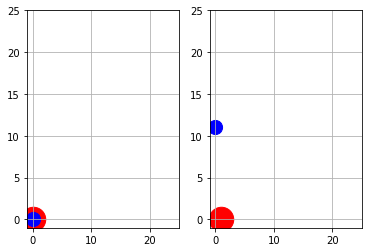

In [ ]:
# plot some states
# TODO: what will state 100 look like? how about others?
import matplotlib.pyplot as pt

pt.subplot(1,2,1)
plot_state(index_to_state(0))
pt.subplot(1,2,2)
plot_state(index_to_state(900))

In [ ]:
# TODO: debug the probability assignment

### Building the transition probability tables (P) for this domain:
# P is a 3d array with shape (K, N, N)
# N is the number of states and K is the number of actions (9 in this case)
# The elements are: P[k,i,j] = Pr(S(t+1) = s_j | S(t) = s_i, A(t)=a_k)

# For this domain, the cat chooses actions uniformly at random
# This means it tries to move in each of the 9 directions with equal probability 1/9
# If the cat tries to move off the grid, it stays in place
# This means that some state transitions occur with higher probability than 1/9
 
def build():
    # Allocate arrays for the probability tables
    P = np.zeros((len(actions), num_states, num_states))

    # Loop over each possible state index
    for i in range(num_states):

        # Convert current index to state and save reward
        state = index_to_state(i)

        # Loop over each possible mouse action
        for a, (dmx, dmy) in enumerate(actions):

            # Loop over each possible cat action
            # Each cat actions is random and equally likely
            for dcx in [-1,0,1]:
                for dcy in [-1,0,1]:

                    # Calculate the new state resulting from mouse/cat motions
                    new_state = move(state, dmx, dmy, dcx, dcy)
                    
                    # Calculate its index in the probability table
                    j = state_to_index(new_state)

                    # Update the current entry in the probability table
                    P[a,i,j] += 1./9. # TODO: what's wrong??????

    # Return the completed probability table and reward vector
    return P

### Sanity check that relevant probabilities sum to one
P = build()

# For every action performed in every state:
for a in range(len(actions)):
    for i in range(num_states):
        
        # The probabilities of all possible new states should sum to 1
        # Due to small numerical round-off errors, just check within 0.001 of 1
        assert(np.fabs(P[a,i,:].sum() - 1.) < .001) # TODO: uncomment


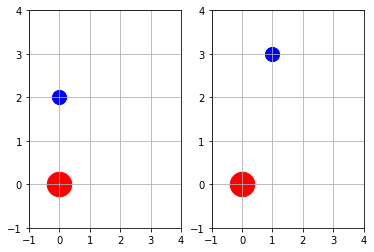

In [ ]:
# run policy iteration to find the optimal policy
π, u_opt = policy_iteration(r,ɣ,P) # returns the optimal policy and utilities

# show optimal action in one state
state = (0, 2, 0, 0) # mouse at (0,2), cat at (0,0)
i = state_to_index(state) # corresponding state index
k = π[i] # policy provides the index of the optimal action in each state
mdx, mdy = actions[k] # get optimal direction for mouse to move
new_state = move(state, mdx, mdy, cdx=0, cdy=0) # new state (if cat stays put)

# Plot old and new state before/after the optimal action as a sanity check
pt.subplot(1,2,1)
plot_state(state)
pt.subplot(1,2,2)
plot_state(new_state)

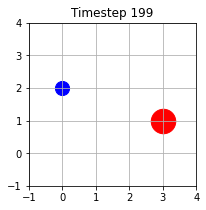

In [ ]:
# Now run the scenario for many time-steps and watch the mouse's behavior

# Run animated simulation
from IPython import display # used for animation

# Arbitrary initial state
state = (0, 0, 3, 0)

# Loop for 200 time-steps
fig = pt.figure(figsize=(3,3)) # each time-step is rendered on this figure
for t in range(200):

    pt.cla() # Clear the figure before redrawing the current state
    plot_state(state) # Draw the current state
    pt.title("Timestep %d" % t)

    # Boiler-plate code for the animation
    display.display(fig) # Display the current figure content
    display.clear_output(wait=True) # don't clear it until new content is ready

    # Move the mouse, either randomly or optimally
    #mdx, mdy = np.random.choice([-1,1],size=2) # random move
    mdx, mdy = actions[π[state_to_index(state)]] # optimal policy move

    # Update the state after the motion for the next time-step
    state = move(state, mdx, mdy)


In [ ]:
# Definition of optimal Q-values, given P tables and optimal utilities
Q_opt = (r + ɣ * (P * u_opt.reshape(1,1,N)).sum(axis=2)).T
print(Q_opt.shape)
print(Q_opt)

(256, 9)
[[1.09374683 1.09374683 1.40471331 ... 1.40471331 1.40471331 1.55649118]
 [2.09374683 2.09374683 2.40471331 ... 3.07234838 3.07234838 3.12270256]
 [3.40471331 3.40471331 3.55649118 ... 4.57234838 4.57234838 4.62270256]
 ...
 [4.62270256 4.57234838 4.57234838 ... 3.55649118 3.40471331 3.40471331]
 [3.12270256 3.07234838 3.07234838 ... 2.40471331 2.09374683 2.09374683]
 [1.55649118 1.40471331 1.40471331 ... 1.40471331 1.09374683 1.09374683]]


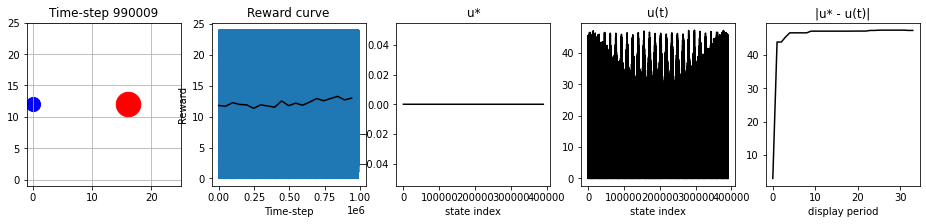

In [ ]:
"""
Using TD Q learning when probabilities and optimal utilities are not accessible
"""

# Initial Q estimates and counts
Q = np.zeros((N, K)) # Repeatedly updated during TD learning
visit_counts = np.zeros(N) # Tracks how many times each state was visited
choice_counts = np.zeros((N, K)) # How many times each action was done in each state

# Reward curve: tracks actual rewards received during learning (should improve)
reward_curve = []
display_period = 30000 # number of time-steps between visualizations
display_window = 10 # how long to animate the animals each visualization
num_buckets = 20 # how many buckets to use for averaging reward in the visualization

# Utility error curve: tracks how close estimate is to convergence
utility_error = []

# Arbitrary initial state when learning begins
state = (0, 0, 3, 0)

# Total number of time-steps for learning
num_timesteps = 10**6
fig, axs = pt.subplots(1, 5, figsize=(16,3)) # subplots for visualization
for t in range(num_timesteps):

    # Get current state index and update visit count
    i = state_to_index(state)
    visit_counts[i] += 1

    # Update the reward curve with the current reward
    reward_curve.append(r[i])

    # Decide whether to explore or exploit
    # Probability of exploring inversely proportional to visit count
    # 1**-1 = 1
    # 100**-1 = .01
    explore = (np.random.rand() < visit_counts[i]**(-1))
    #explore = True

    # TODO: different explore strategy for better u* estimate?

    # Choose an action
    # Uniformly at random if exploring
    # Best current Q estimate if exploiting
    k = np.random.randint(K) if explore else Q[i,:].argmax()

    # Update the action count and perform the chosen action
    choice_counts[i, k] += 1
    mdx, mdy = actions[k]
    state = move(state, mdx, mdy)

    # TD update rule
    # α is the state-dependent learning rate, should get smaller over time
    # j is the new state index after the current action is performed
    α = 1./choice_counts[i,k] # TODO: different α formula for better rewards?
    j = state_to_index(state)
    Q[i,k] = (1-α) * Q[i,k] + α * (r[i] + ɣ * Q[j,:].max())

    # Visualize progress
    if False or (t % display_period < display_window):

        # Render the current state
        pt.sca(axs[0])
        pt.cla()
        plot_state(state)
        pt.title("Time-step %d" % t)
        
        # Plot the reward curve
        pt.sca(axs[1])
        pt.cla()
        pt.plot(reward_curve)
        # For a smoother plot, average the reward curve in buckets
        if t > num_buckets:
            trim = int(t / num_buckets) * num_buckets
            reward_buckets = np.array(reward_curve[:trim]).reshape(num_buckets,-1).mean(axis=1)
            pt.plot(np.arange(0, trim, int(t / num_buckets)), reward_buckets, 'k-')
        pt.xlabel("Time-step")
        pt.ylabel("Reward")
        pt.title("Reward curve")

        # Plot the optimal utility
        # Unknown to the agent, just shown for benchmarking
        # Just show all zeros if P tables were too large
        pt.sca(axs[2])
        pt.cla()
        pt.plot(u_opt, 'k-')
        pt.xlabel("state index")
        if u_opt.max() > 0: pt.ylim([0, u_opt.max() * 1.1])
        pt.title("u*")

        # Compute estimated utilities based on current Q estimates
        u = Q.max(axis=1) # what does this mean???

       # Plot current utility to compare with optimal utility
        pt.sca(axs[3])
        pt.cla()
        pt.plot(u, 'k-')
        pt.xlabel("state index")
        if u_opt.max() > 0: pt.ylim([0, u_opt.max() * 1.1])
        pt.title("u(t)")

        # Update utility error curve
        if t % display_period == 0:
            utility_error.append(np.fabs(u - u_opt).max())
        
        # Plot utility error curve
        pt.sca(axs[4])
        pt.cla()
        pt.plot(utility_error, 'k-')
        pt.xlabel("display period")
        pt.title("|u* - u(t)|")
 
        # Boiler-plate code for the animation
        display.display(fig) # Display the current figure content
        display.clear_output(wait=True) # don't clear it until new content is ready
